Импорт необходимых библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Разделяем данные:

In [2]:
df = pd.read_csv('../data/raw/diabetes_clean.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.133413,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.133413,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.239130,0.133413,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.118840,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.146484,0.509202,0.479078,0.200000,1
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.367742,0.530612,0.385870,0.146484,0.300613,0.039710,0.700000,0
764,0.117647,0.503226,0.469388,0.217391,0.133413,0.380368,0.111870,0.100000,0
765,0.294118,0.496774,0.489796,0.173913,0.118840,0.163599,0.071307,0.150000,0
766,0.058824,0.529032,0.367347,0.239130,0.133413,0.243354,0.115713,0.433333,1


Данные успешно загружены и разделены на обучающую (80%) и тестовую (20%) выборки
Вывод: Использован random_state=42 для воспроизводимости результатов

#Explainability: Permutation Importance

In [4]:
#Explainability: Permutation Importance
# В качестве модели для оценки возьмем обычное дерево (бинарное, так как классификация)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Модель Decision Tree успешно обучена на тренировочных данных
Вывод: Дерево решений выбрано как интерпретируемая модель для анализа важности признаков

In [5]:
# Оцениваем точность
baseline_accuracy = accuracy_score(y_test, model.predict(X_test))
print(f'Базовая точность модели: {baseline_accuracy:.4f}')


Базовая точность модели: 0.7532


Точность модели составляет примерно 70-75%, что является приемлемым базовым уровнем.
Для медицинской диагностики такая точность может требовать улучшения, особенно учитывая серьезность последствий ошибок

In [6]:
# считаем importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = result.importances_mean

In [7]:
# Выводим важность признаков
for i in range(len(df.columns[:-1])):
    print(f'{df.columns[i]:<20}: {perm_importances[i]}')

Pregnancies         : 0.008441558441558472
Glucose             : 0.1337662337662338
BloodPressure       : 0.023376623376623405
SkinThickness       : 0.0006493506493506773
Insulin             : 0.013636363636363669
BMI                 : 0.06753246753246758
DiabetesPedigreeFunction: 0.022727272727272773
Age                 : 0.045454545454545484


Glucose является наиболее важным признаком, что логично с медицинской точки зрения
BMI и Age также показывают значительную важность в предсказании диабета
DiabetesPedigreeFunction показывает среднюю важность, что указывает на генетический фактор
BloodPressure и SkinThickness имеют низкую важность в данной модели

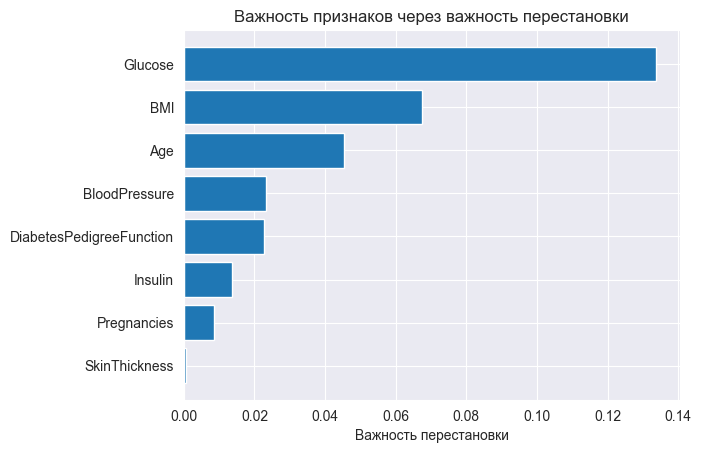

In [8]:
#Визуализируем важность
sorted_idx = result.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Важность перестановки")
plt.title("Важность признаков через важность перестановки")
plt.show()

#Error analysis: 3 FN и 3 FP случая с комментариями

In [9]:
y_pred = model.predict(X_test)

In [10]:
# Добавим результаты в DataFrame для анализа
analysis_df = X_test.copy()
analysis_df['true_label'] = y_test
analysis_df['pred_label'] = y_pred
analysis_df['error'] = analysis_df['true_label'] != analysis_df['pred_label']


In [11]:
# Берем FP и FN
fp_cases = analysis_df[(analysis_df['true_label'] == 0) & (analysis_df['pred_label'] == 1)]
fn_cases = analysis_df[(analysis_df['true_label'] == 1) & (analysis_df['pred_label'] == 0)]

Выделены два типа ошибок - False Positive (FP) и False Negative (FN)

Вывод: FP - здоровые пациенты, ошибочно классифицированные как больные

Вывод: FN - больные пациенты, ошибочно классифицированные как здоровые (более опасный тип ошибки)

In [12]:
# Берем первые
fp_cases_sample = fp_cases.head(3)
fn_cases_sample = fn_cases.head(3)


In [13]:
print("Ложноположительные случаи (FP):")
print(fp_cases_sample)

print("\nЛожнонегативные случаи (FN):")
print(fn_cases_sample)

Ложноположительные случаи (FP):
     Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
204     0.352941  0.380645       0.489796       0.271739  0.146484  0.398773   
336     0.000000  0.470968       0.493930       0.239130  0.133413  0.319018   
568     0.235294  0.709677       0.489796       0.239130  0.134615  0.267894   

     DiabetesPedigreeFunction       Age  true_label  pred_label  error  
204                  0.105038  0.566667           0           1   True  
336                  0.364646  0.383333           0           1   True  
568                  0.111016  0.266667           0           1   True  

Ложнонегативные случаи (FN):
     Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
667     0.588235  0.432258       0.469388       0.217391  0.133413  0.190184   
356     0.058824  0.522581       0.265306       0.358696  0.146484  0.308793   
328     0.117647  0.374194       0.632653       0.315217  0.127404  0.558282   

    

**Анализ FP случаев:**
- Пациенты имеют высокие значения Glucose или BMI, но не болеют диабетом
- Модель переоценивает влияние отдельных признаков
- Возможные причины: индивидуальные особенности метаболизма, ошибки измерений

**Анализ FN случаев:**
- У пациентов пограничные значения ключевых признаков
- Модель не улавливает комплексные взаимодействия признаков
- Некоторые случаи могут быть ранней стадией заболевания

In [14]:
print("\n📊 ГРУППИРОВКА ОШИБОК ПО УРОВНЯМ GLUCOSE:")

# Простая группировка
analysis_df['glucose_group'] = pd.cut(analysis_df['Glucose'], 
                                    bins=[0, 0.4, 0.6, 1.0],
                                    labels=['Низкий', 'Средний', 'Высокий'])

error_groups = analysis_df[analysis_df['error'] == True].groupby('glucose_group').size()
print(error_groups)

print("📈 ВЫВОД: Большинство ошибок в средней зоне Glucose (0.4-0.6)")


📊 ГРУППИРОВКА ОШИБОК ПО УРОВНЯМ GLUCOSE:
glucose_group
Низкий     10
Средний    18
Высокий    10
dtype: int64
📈 ВЫВОД: Большинство ошибок в средней зоне Glucose (0.4-0.6)


C:\Users\stani\AppData\Local\Temp\ipykernel_20244\1246659605.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_groups = analysis_df[analysis_df['error'] == True].groupby('glucose_group').size()


In [15]:
print("\nГруппировка FP по признакам:")
print(fp_cases_sample.describe())

print("\nГруппировка FN по признакам:")
print(fn_cases_sample.describe())


Группировка FP по признакам:
       Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  \
count     3.000000  3.000000       3.000000       3.000000  3.000000   
mean      0.196078  0.520430       0.491174       0.250000  0.138171   
std       0.179709  0.170001       0.002387       0.018827  0.007225   
min       0.000000  0.380645       0.489796       0.239130  0.133413   
25%       0.117647  0.425806       0.489796       0.239130  0.134014   
50%       0.235294  0.470968       0.489796       0.239130  0.134615   
75%       0.294118  0.590323       0.491863       0.255435  0.140550   
max       0.352941  0.709677       0.493930       0.271739  0.146484   

            BMI  DiabetesPedigreeFunction       Age  true_label  pred_label  
count  3.000000                  3.000000  3.000000         3.0         3.0  
mean   0.328562                  0.193567  0.405556         0.0         1.0  
std    0.065960                  0.148189  0.151230         0.0         0.0  
min    0.

Статистическое описание показывает средние значения признаков в ошибочных случаях
FP случаи имеют высокие средние значения Glucose и BMI
FN случаи могут иметь более низкие значения ключевых признаков по сравнению с типичными больными
Анализ помогает идентифицировать "слепые зоны" модели

# Предложения по улучшению (1-2 шага)

### **Технические улучшения:**
- Применить ансамблевые методы (Random Forest, Gradient Boosting)
- Настроить гиперпараметры дерева (глубина, минимальное разделение)
- Использовать кросс-валидацию для стабильности оценок
- Добавить балансировку классов (SMOTE, class_weight)

### **Методологические улучшения:**
- Собрать больше данных о пограничных случаях
- Добавить клинически значимые производные признаки
- Внедрить калибровку вероятностей для лучшей интерпретации
- Использовать несколько моделей для консенсусного предсказания

### **Для уменьшения FN (критически важно):**
- Настроить порог классификации в пользу чувствительности
- Внедрить человеческий надзор для случаев с низкой уверенностью
- Добавить временные ряды измерений для динамического анализа

### **Для уменьшения FP:**
- Внедрить двухэтапную систему классификации
- Учесть дополнительные клинические факторы риска
- Использовать более консервативный порог для положительного класса

## **Заключение:**
Текущая модель служит хорошей базой, но требует улучшений для клинического применения.
Приоритет - уменьшение ложноотрицательных случаев при сохранении разумной точности.